In [50]:
%matplotlib inline
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.io import wavfile
from scipy import signal as scisig

In [51]:
sess = tf.InteractiveSession()

In [52]:
sample_rate = 16000 # Hz
X = tf.placeholder(tf.float32, shape=[None])

nunits = 16
filter_time = 0.05 # seconds
lfilter = int(filter_time*sample_rate) # number of samples in a filter
# initialize filters...they get set to gammachirps later, though
filters = tf.Variable(tf.random_normal([nunits, lfilter]))

Xnow = tf.placeholder(tf.float32, shape=[lfilter])
filX = tf.squeeze(tf.matmul(filters, tf.expand_dims(Xnow,dim=1)))
candidate = tf.cast(tf.argmax(filX, axis=0), tf.int32)
cand_contrib = tf.scalar_mul(filX[candidate],filters[candidate,:])

# define op for learning (which I haven't done yet), not sure the reconstruction is right
final_coeffs = tf.placeholder(tf.float32, shape=[nunits, None])
Xhat = tf.nn.convolution(tf.expand_dims(final_coeffs, dim=0), 
                         tf.transpose(tf.expand_dims(filters, dim=2),[1,0,2]),
                         padding="VALID", data_format="NCW") # needs attention
loss = tf.reduce_mean(tf.square(X - tf.squeeze(Xhat)))
learn_rate = 0.01
learner = tf.train.GradientDescentOptimizer(learn_rate)
learn_step = tf.Variable(0,name='learn_step', trainable=False)
learn_op = learner.minimize(loss, global_step=learn_step, var_list=[filters])

In [53]:
def infer(signal, lam):
    lsig = signal.shape[0]
    resid = signal.copy()
    spikes = np.zeros([nunits, lsig])
    for tt in range(lfilter, lsig):
        filout, cand, contrib = sess.run((filX, candidate, cand_contrib), feed_dict = {Xnow : resid[tt-lfilter:tt]})
        sp = filout[cand]
        if sp > lam:
            resid[tt-lfilter:tt] -= contrib
            spikes[cand, tt] = sp
    return spikes

In [54]:
# dynamic compressive gammachirp
def dcGC(t,f):
    """Dynamic compressive gammachirp filter as defined by Irino,
    with parameters from Park as used in Charles, Kressner, & Rozell.
    The log term is regularized to log(t + 0.00001).
    t : time in seconds, greater than 0
    f : characteristic frequency in Hz
    One but not both arguments may be numpy arrays.
    """
    ERB = 0.1039*f + 24.7
    return t**3 * np.exp(-2*np.pi*1.14*ERB*t) * np.cos(2*np.pi*f*t + 0.979*np.log(t+0.000001))

gammachirps = np.zeros([nunits, lfilter])
freqs = np.logspace(np.log10(100), np.log10(6000), nunits)
times = np.linspace(0,filter_time,lfilter)
for ii in range(nunits):
    gammachirps[ii] = dcGC(times, freqs[ii])

In [55]:
sess.run(tf.global_variables_initializer())
sess.run(filters.assign(tf.constant(gammachirps.reshape([nunits,lfilter]), dtype=tf.float32)))
sess.run(filters.assign(tf.nn.l2_normalize(filters, dim=1)))

array([[  0.00000000e+00,  -2.41232442e-07,  -1.43578029e-06, ...,
         -4.42481949e-04,  -4.34583431e-04,  -4.26102517e-04],
       [  0.00000000e+00,  -2.40850511e-07,  -1.40054340e-06, ...,
          1.19512799e-04,   1.14035021e-04,   1.08367109e-04],
       [  0.00000000e+00,  -2.40294014e-07,  -1.35325297e-06, ...,
          1.88831182e-05,   1.69557297e-05,   1.50029482e-05],
       ..., 
       [  0.00000000e+00,  -4.89290848e-08,   1.35157711e-06, ...,
          0.00000000e+00,   0.00000000e+00,  -0.00000000e+00],
       [  0.00000000e+00,   3.68632058e-08,   5.85180089e-07, ...,
         -0.00000000e+00,  -0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   1.25304950e-07,  -6.55938209e-07, ...,
          0.00000000e+00,   0.00000000e+00,  -0.00000000e+00]], dtype=float32)

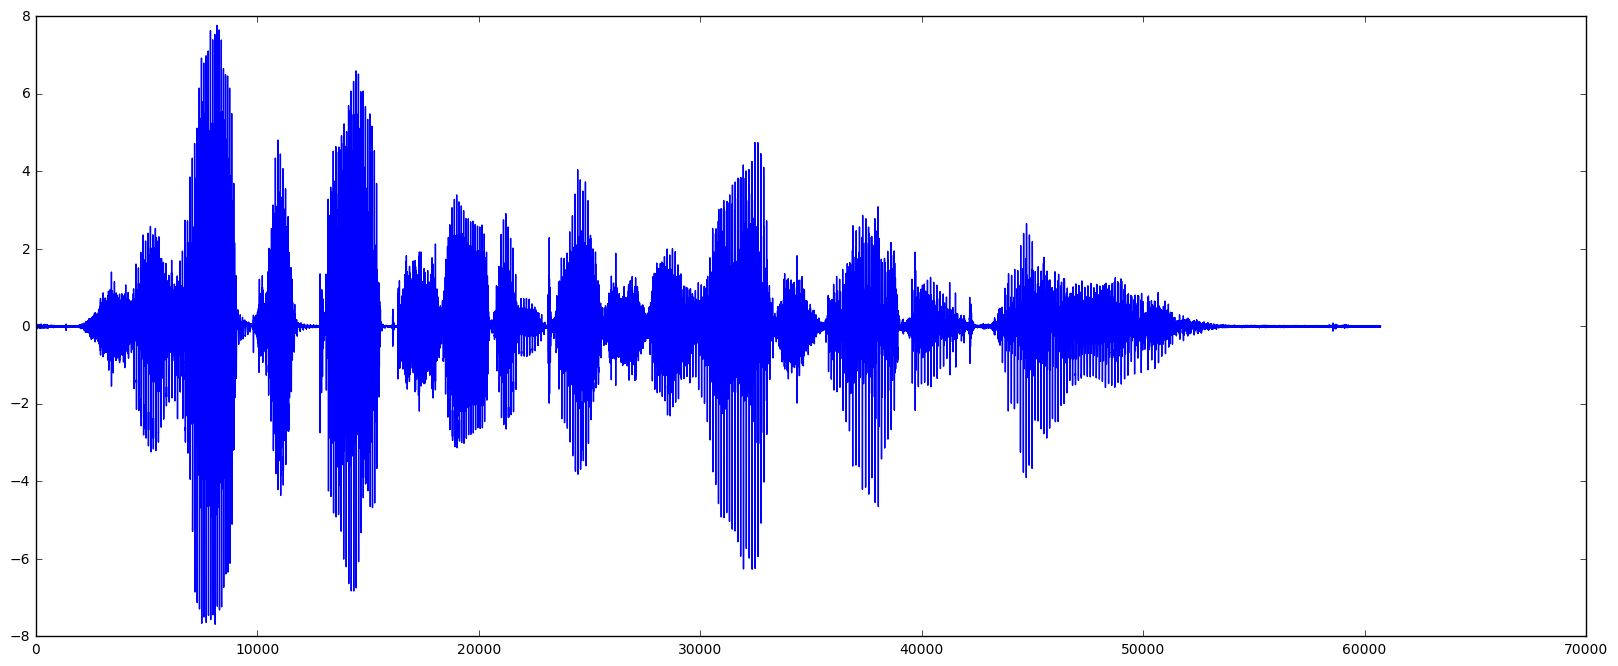

In [56]:
folder = '../Data/TIMIT/'
files = os.listdir(folder)
file = None
for ff in files:
    if ff.endswith('.wav'):
        file = os.path.join(folder,ff)
        break
rate, signal = wavfile.read(file)
# bandpass
signal = signal/signal.std()

# adapted from scipy cookbook
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = scisig.butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = scisig.lfilter(b, a, data)
    return y

lowcut = 100
highcut = 6000
signal = butter_bandpass_filter(signal, lowcut, highcut, sample_rate, order=5)

plt.figure(figsize=(20,8))
plt.plot(signal)

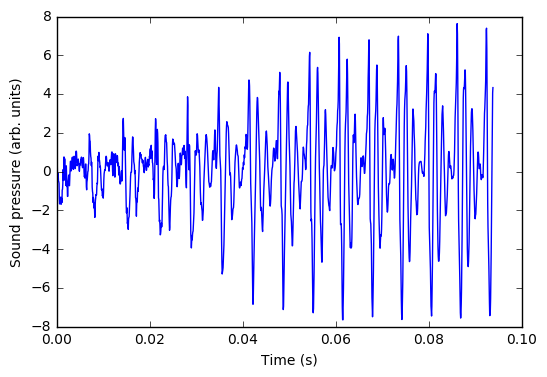

In [57]:
start = 6500
end = 8000
times = np.linspace(0, (end - start)/sample_rate,end-start)
plt.plot(times, signal[start:end])
plt.xlabel('Time (s)')
plt.ylabel('Sound pressure (arb. units)')

In [58]:
spikes = infer(signal[start:end], 0.2)

In [59]:
def plotSpikeGram( spikes, markerSize = .0001 ):
    """adapted from https://github.com/craffel/spikegram-coding/blob/master/plotSpikeGram.py"""
    nkernels = spikes.shape[0]
    indices = np.transpose(np.nonzero(spikes))
    print(indices.shape)
    scalesKernelsAndOffsets = [(spikes[idx[0],idx[1]], idx[0], idx[1]) for idx in indices]
    
    for scale, kernel, offset in scalesKernelsAndOffsets:
        # Put a dot at each spike location.  Kernels on y axis.  Dot size corresponds to scale
        plt.plot( offset/sample_rate, nkernels-kernel, 'k.', markersize=markerSize*np.abs( scale ) )
    plt.title( "Spikegram" )
    plt.xlabel( "Time (s)" )
    plt.ylabel( "Kernel" )
    plt.axis( [0.0, spikes.shape[1]/sample_rate, 0.0, nkernels] )
    plt.show()

(641, 2)


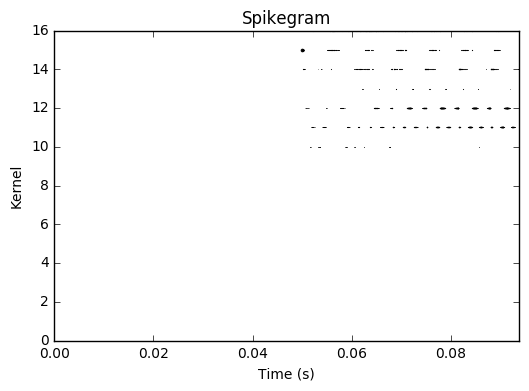

In [60]:
plotSpikeGram(spikes, 1)

In [61]:
feed_dict = {X : signal[start:end], final_coeffs : spikes}
sess.run(learn_op, feed_dict = feed_dict)

InvalidArgumentError: Incompatible shapes: [1500] vs. [701]
	 [[Node: sub_3 = Sub[T=DT_FLOAT, _device="/job:localhost/replica:0/task:0/gpu:0"](_recv_Placeholder_24_0/_35, Squeeze_11)]]

Caused by op 'sub_3', defined at:
  File "/home/edodds/anaconda3/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/edodds/anaconda3/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/edodds/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/home/edodds/anaconda3/lib/python3.5/site-packages/traitlets/config/application.py", line 653, in launch_instance
    app.start()
  File "/home/edodds/anaconda3/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 474, in start
    ioloop.IOLoop.instance().start()
  File "/home/edodds/anaconda3/lib/python3.5/site-packages/zmq/eventloop/ioloop.py", line 162, in start
    super(ZMQIOLoop, self).start()
  File "/home/edodds/anaconda3/lib/python3.5/site-packages/tornado/ioloop.py", line 887, in start
    handler_func(fd_obj, events)
  File "/home/edodds/anaconda3/lib/python3.5/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/edodds/anaconda3/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/home/edodds/anaconda3/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/edodds/anaconda3/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/home/edodds/anaconda3/lib/python3.5/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/edodds/anaconda3/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 276, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/edodds/anaconda3/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 228, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/edodds/anaconda3/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 390, in execute_request
    user_expressions, allow_stdin)
  File "/home/edodds/anaconda3/lib/python3.5/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/edodds/anaconda3/lib/python3.5/site-packages/ipykernel/zmqshell.py", line 501, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/edodds/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2717, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/edodds/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2821, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/edodds/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-52-750d95892e88>", line 20, in <module>
    loss = tf.reduce_mean(tf.square(X - tf.squeeze(Xhat)))
  File "/home/edodds/anaconda3/lib/python3.5/site-packages/tensorflow/python/ops/math_ops.py", line 814, in binary_op_wrapper
    return func(x, y, name=name)
  File "/home/edodds/anaconda3/lib/python3.5/site-packages/tensorflow/python/ops/gen_math_ops.py", line 2758, in sub
    result = _op_def_lib.apply_op("Sub", x=x, y=y, name=name)
  File "/home/edodds/anaconda3/lib/python3.5/site-packages/tensorflow/python/framework/op_def_library.py", line 759, in apply_op
    op_def=op_def)
  File "/home/edodds/anaconda3/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 2240, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/home/edodds/anaconda3/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 1128, in __init__
    self._traceback = _extract_stack()

InvalidArgumentError (see above for traceback): Incompatible shapes: [1500] vs. [701]
	 [[Node: sub_3 = Sub[T=DT_FLOAT, _device="/job:localhost/replica:0/task:0/gpu:0"](_recv_Placeholder_24_0/_35, Squeeze_11)]]
